Trading Analysis Notebook - Part 2

This notebook contains analyses for:
1. Return Distribution
2. Leverage where the ratio of our notional value to capital
3. Strategy return Convexity 
4. Capital Returns 
5. 30 day rolling sharpe and portfolio vol

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from scipy import stats
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.ticker as ticker
from IPython.display import display

sns.set_theme()

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
# Load data
df = pd.read_csv('../data/capital_returns.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %I:%M:%S %p')

print("\nFirst few rows:")
display(df.head())


First few rows:


,Timestamp,CapitalReturn,Position,EntryPrice,CurrentPrice,MarketPosition,Leverage
0,2017-01-09 23:30:00,0.0,0,0.0,5009.50,False,0.0
1,2017-01-10 00:00:00,0.0,0,0.0,5010.75,False,0.0
2,2017-01-10 00:30:00,0.0,0,0.0,5010.00,False,0.0
3,2017-01-10 01:00:00,0.0,0,0.0,5012.00,False,0.0
4,2017-01-10 01:30:00,0.0,0,0.0,5012.00,False,0.0


1. Return Distribution Analysis

This analysis examines the distribution of returns during positions.


Return Statistics:
Mean: 0.0241
Std Dev: 0.0450
Kurtosis: 21.68
Skewness: 3.70


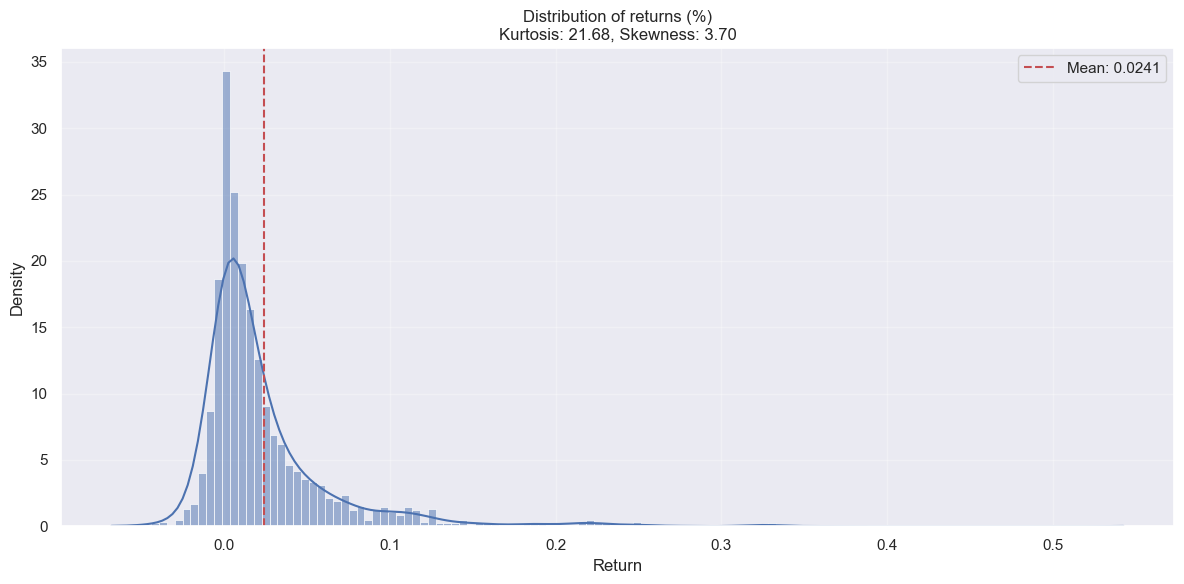

In [3]:
def analyze_position_returns(df):
    position_returns = []
    position_start = None
    current_returns = []
    
    for i in range(1, len(df)):
        # Detect position start (0 to non-zero)
        if df.iloc[i-1]['Position'] == 0 and df.iloc[i]['Position'] != 0:
            position_start = df.iloc[i]['Timestamp']
            current_returns = []
            
        # Collect returns during position
        if position_start is not None:
            current_returns.append(df.iloc[i]['CapitalReturn'])
            
        # Detect position end (non-zero to 0)
        if position_start is not None and df.iloc[i]['Position'] == 0:
            # Sum returns for complete trade
            position_returns.append(sum(current_returns))
            position_start = None
    
    return np.array(position_returns)

# Calculate return statistics
returns = analyze_position_returns(df)
mean_return = returns.mean()
kurtosis = stats.kurtosis(returns)
skewness = stats.skew(returns)

print(f"\nReturn Statistics:")
print(f"Mean: {mean_return:.4f}")
print(f"Std Dev: {returns.std():.4f}")
print(f"Kurtosis: {kurtosis:.2f}")
print(f"Skewness: {skewness:.2f}")

# Create distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(data=returns, kde=True, stat='density')
plt.axvline(mean_return, color='r', linestyle='--', label=f'Mean: {mean_return:.4f}')

plt.title(f'Distribution of returns (%)\nKurtosis: {kurtosis:.2f}, Skewness: {skewness:.2f}')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

2. Leverage Analysis

This analysis shows the evolution of position leverage over time.

Leverage Statistics:
Mean Leverage: 6.64
Max Leverage: 17.73
Min Leverage: 0.16


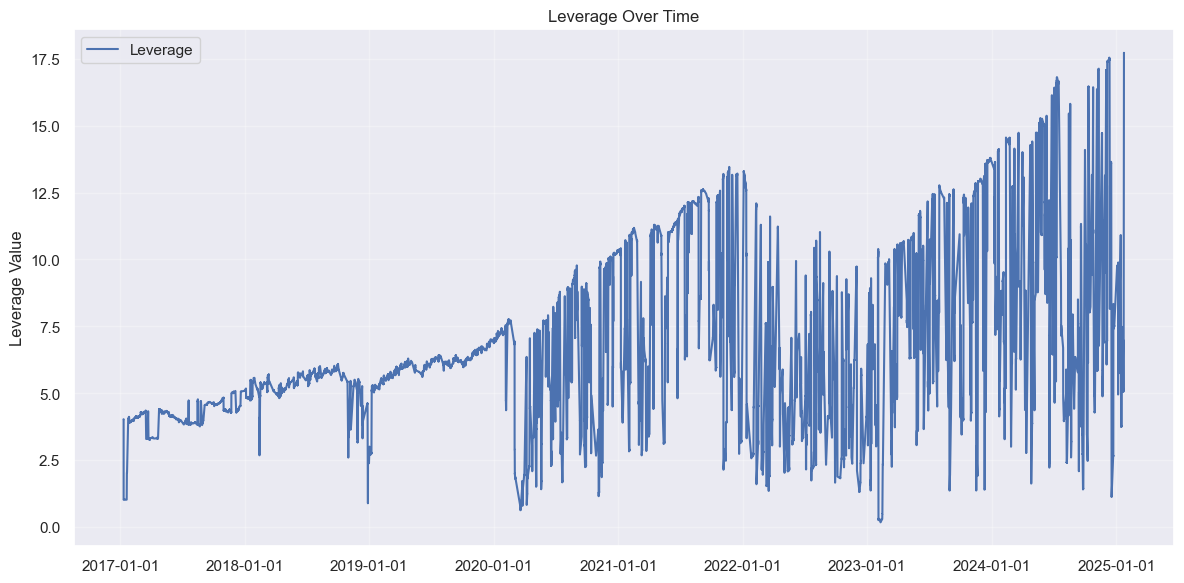

In [4]:
def plot_leverage(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot leverage excluding zero values
    leverage_data = df[df['Leverage'] != 0]
    ax.plot(leverage_data['Timestamp'], leverage_data['Leverage'], label='Leverage')
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(AutoDateLocator())
    
    plt.title('Leverage Over Time')
    plt.ylabel('Leverage Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Print leverage statistics
    print(f"Leverage Statistics:")
    print(f"Mean Leverage: {leverage_data['Leverage'].mean():.2f}")
    print(f"Max Leverage: {leverage_data['Leverage'].max():.2f}")
    print(f"Min Leverage: {leverage_data['Leverage'].min():.2f}")
    
    return fig

# Plot leverage
fig_leverage = plot_leverage(df)
plt.show()

3. TQQQ Convexity Analysis

This analysis examines the relationship between strategy returns and TQQQ returns.

[*********************100%***********************]  1 of 1 completed


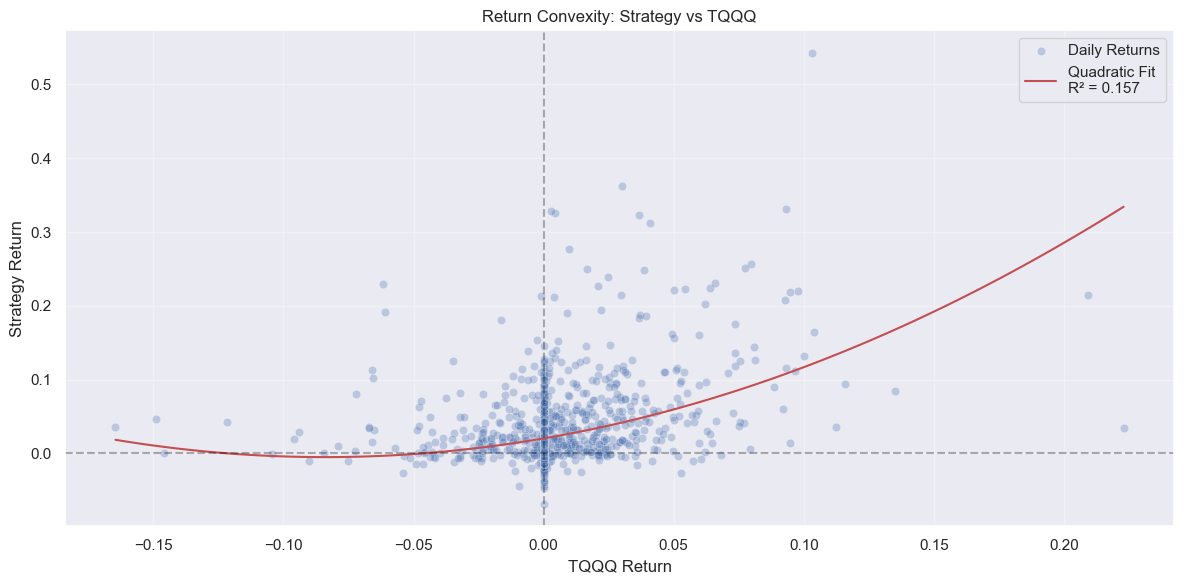

                            OLS Regression Results                            
Dep. Variable:           trend_return   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     163.9
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           5.14e-66
Time:                        21:56:03   Log-Likelihood:                 3118.1
No. Observations:                1763   AIC:                            -6230.
Df Residuals:                    1760   BIC:                            -6214.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0203      0.001     20.100      0.0

In [5]:
def analyze_convexity(df):
    # Group positions and calculate returns
    def analyze_position_returns(trend_data, tqqq_data):
        positions = []
        position_start = None
        
        for i in range(1, len(trend_data)):
            # Detect position start
            if trend_data.iloc[i-1]['Position'] == 0 and trend_data.iloc[i]['Position'] != 0:
                position_start = trend_data.iloc[i]['Timestamp']
                position_returns = []
            
            # Collect returns during position
            if position_start is not None:
                position_returns.append(trend_data.iloc[i]['CapitalReturn'])
            
            # Detect position end
            if position_start is not None and trend_data.iloc[i]['Position'] == 0:
                position_end = trend_data.iloc[i]['Timestamp']
                
                # Get TQQQ returns for position period
                tqqq_mask = (tqqq_data['Date'] >= position_start) & (tqqq_data['Date'] <= position_end)
                tqqq_return = tqqq_data.loc[tqqq_mask, 'Returns'].sum()
                
                positions.append({
                    'start_date': position_start,
                    'end_date': position_end,
                    'tqqq_return': tqqq_return,
                    'trend_return': sum(position_returns)
                })
                position_start = None
        
        return pd.DataFrame(positions)

    # Get TQQQ data
    tqqq = yf.download('TQQQ', 
                       start=df['Timestamp'].min().strftime('%Y-%m-%d'),
                       end=df['Timestamp'].max().strftime('%Y-%m-%d'))
    tqqq['Returns'] = tqqq['Close'].pct_change()
    tqqq = tqqq.reset_index()[['Date', 'Returns']]
    tqqq['Date'] = pd.to_datetime(tqqq['Date'])

    # Calculate position returns
    position_returns = analyze_position_returns(df, tqqq)

    if not position_returns.empty:
        # Fit quadratic model
        X = position_returns['tqqq_return']
        X_quad = np.column_stack((X, X**2))
        X_with_const = sm.add_constant(X_quad)
        y = position_returns['trend_return']

        model = sm.OLS(y, X_with_const).fit()

        # Create plot
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x=X, y=y, alpha=0.3, label='Daily Returns')

        # Generate smooth curve for quadratic fit
        X_range = np.linspace(X.min(), X.max(), 100)
        X_quad_plot = np.column_stack((X_range, X_range**2))
        X_quad_plot = sm.add_constant(X_quad_plot)
        y_pred = model.predict(X_quad_plot)

        plt.plot(X_range, y_pred, 'r', label=f'Quadratic Fit\nR² = {model.rsquared:.3f}')

        plt.axhline(0, color='black', linestyle='--', alpha=0.3)
        plt.axvline(0, color='black', linestyle='--', alpha=0.3)

        plt.title('Return Convexity: Strategy vs TQQQ')
        plt.xlabel('TQQQ Return')
        plt.ylabel('Strategy Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(model.summary())
        
        print("\nKey Metrics:")
        print(f"Alpha: {model.params.iloc[0]:.4f}")
        print(f"Beta: {model.params.iloc[1]:.4f}")
        print(f"Beta²: {model.params.iloc[2]:.4f}")
        print(f"R²: {model.rsquared:.4f}")
    else:
        print("\nNo positions found in the data")

# Run convexity analysis
analyze_convexity(df)

4. Capital Returns Analysis

This analysis examines the trade systems capital returns


Strategy Metrics:
Volatility: 13.90%
Sharpe Ratio: 3.02
Sortino Ratio: 5.41
Max Drawdown: -11.64%


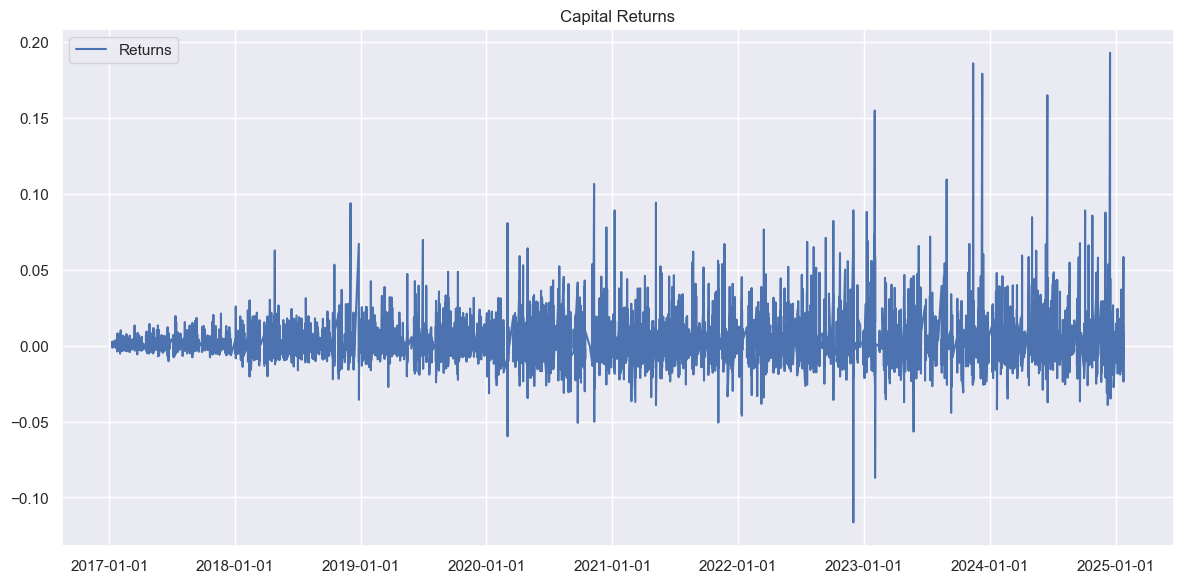

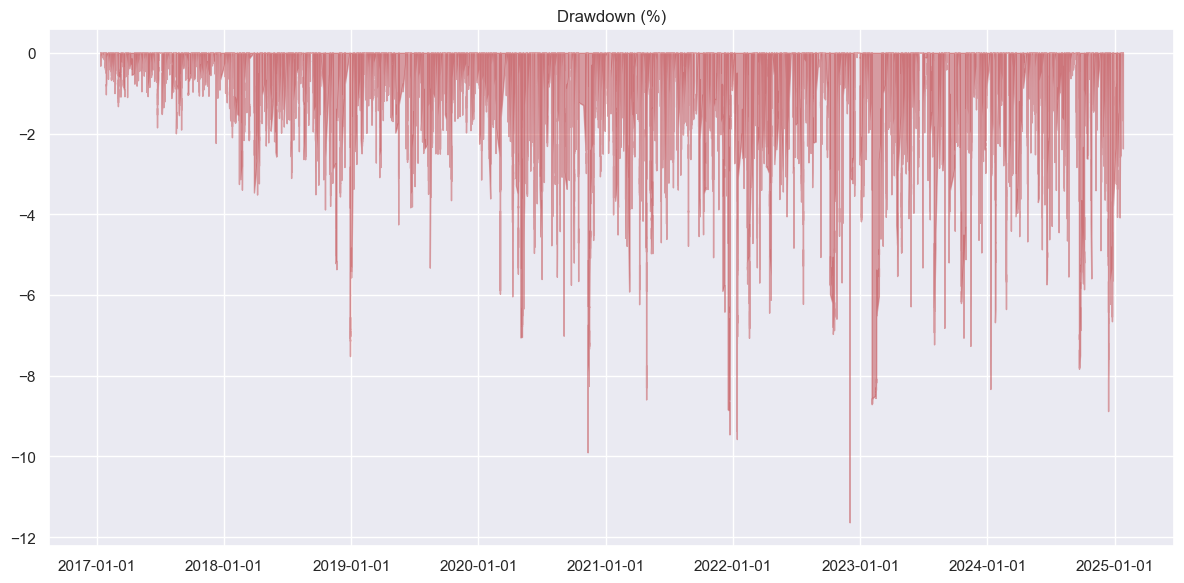

In [6]:
def analyze_capital_returns(df):
    # Filter out zeros for capital returns
    df_nonzero = df[df['CapitalReturn'] != 0].copy()
    returns = df_nonzero['CapitalReturn']
    
    # Calculate metrics
    volatility = returns.std() * np.sqrt(253)
    sharpe = returns.mean() / returns.std() * np.sqrt(253)
    sortino = returns.mean() / returns[returns < 0].std() * np.sqrt(253)
    
    # Calculate drawdown series
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    print("\nStrategy Metrics:")
    print(f"Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Sortino Ratio: {sortino:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Create first plot - Returns
    plt.figure(figsize=(12, 6))
    plt.plot(df_nonzero['Timestamp'], returns, label='Returns')
    plt.title('Capital Returns')
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.tight_layout()
    plt.show()
    
    # Create second plot - Drawdown
    plt.figure(figsize=(12, 6))
    plt.fill_between(df_nonzero['Timestamp'], drawdowns * 100, 0, color='r', alpha=0.5)
    plt.title('Drawdown (%)')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_capital_returns(df)

5. Rolling Metrics Analysis

This analysis examines the 30d rolling Sharpe ratio and portfolio vol

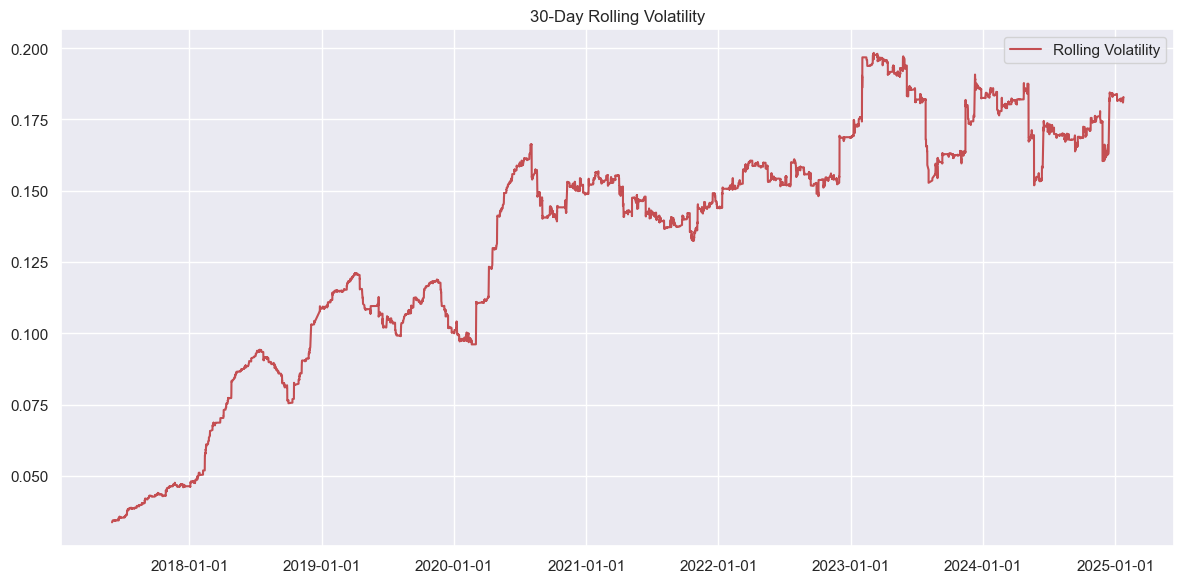

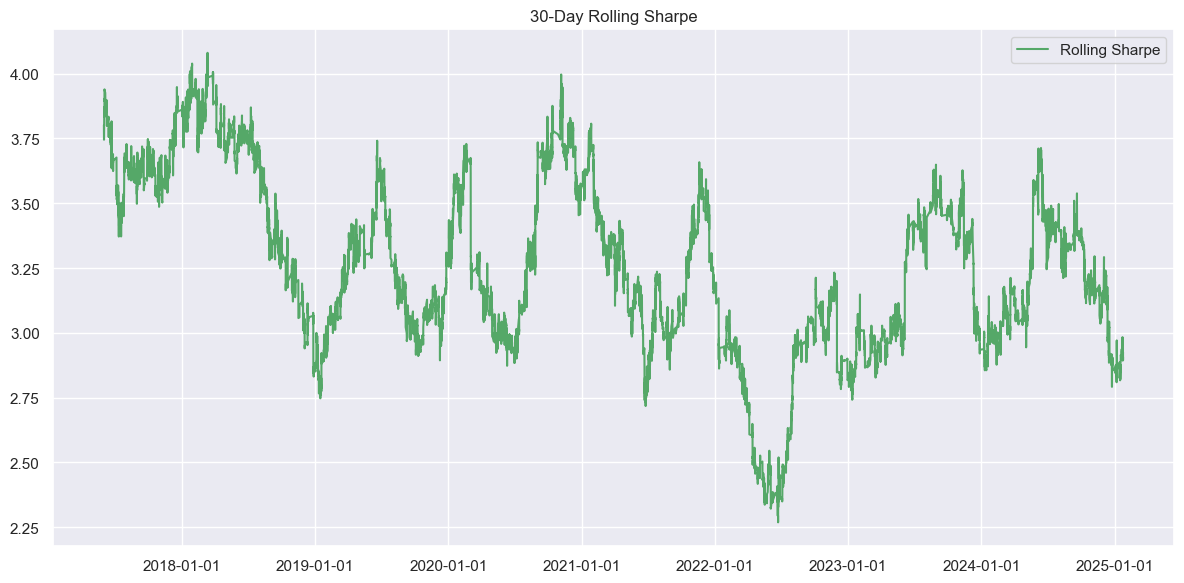

In [7]:
def analyze_rolling_metrics(df, window=30*48):  # 30 days * 48 periods per day
    # Filter out zeros for capital returns
    df_nonzero = df[df['CapitalReturn'] != 0].copy()
    returns = df_nonzero['CapitalReturn']
    
    # Calculate rolling metrics
    rolling_vol = returns.rolling(window).std() * np.sqrt(253)
    rolling_mean = returns.rolling(window).mean()
    rolling_sharpe = (rolling_mean / returns.rolling(window).std()) * np.sqrt(253)
    
    # Create first plot - Rolling Volatility
    plt.figure(figsize=(12, 6))
    plt.plot(df_nonzero['Timestamp'], rolling_vol, 'r', label='Rolling Volatility')
    plt.title('30-Day Rolling Volatility')
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.tight_layout()
    plt.show()
    
    # Create second plot - Rolling Sharpe
    plt.figure(figsize=(12, 6))
    plt.plot(df_nonzero['Timestamp'], rolling_sharpe, 'g', label='Rolling Sharpe')
    plt.title('30-Day Rolling Sharpe')
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.tight_layout()
    plt.show()

# Run rolling metrics analysis
analyze_rolling_metrics(df)